### drifting the periodically force Harper model?

In [ ]:
# I need to edit this as I have updated much of the code. See Qperio11.ipynb

In [2]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import mpmath as mpmath

# %matplotlib notebook 
%matplotlib inline 

import Husimi   # quantum routines
import Harp     # Classical integration routines
import importlib  # for reloading routines

### issue:
Should we be varying H while doing each propagator?
We might want to slowly compute eigenvalues but we probably
also want to drift the system smoothly because that is what we would be doing with the classical system?

In [27]:
importlib.reload(Husimi)  # if you need to reload it!

<module 'Husimi' from '/Users/aquillen/Desktop/summer24/pylab/QI_explore/Husimi.py'>

In [ ]:
importlib.reload(Harp)  # if you need to reload it!

In [65]:
# change this so is in order of <h0>?

# record a series of eigenvalues for a series of operators 
# slowly and linearly varying parameters
# arguments:
#   n: dim of Hilbert space
#   ntau: number of Trotterization steps to take
#   parms: is [a,b,eps,mu,mup] for periodically perturbed Harper model
#   dparms: is change in these values across a period
#   nseries: number of steps to take in our adiabatic variation, each step is a period
# returns:
#   U_list[nseries,n,n]  3 index matrix, storing propagators across each period
#   w_list[nseries,n]:  2 index matrix nseries, list of quasienergies for each UT at each step, increasing order (phase =quasienergies) 
#   vr_list[nseries,n,n]:  3 index matrix, list of eigenvecs for each UT, order phase 
#   wsort_list[nseries,n]:  list of quasienergies of current UT but in order <h_0> where h_0 is current operator h_0
#   vrsort_list[nseries,n,n]:  list of eigenvecs of current UT in order of <h_0>
#   expsort_list[nseries,n]:   list of <h_0> of current UT, increasing order 
#   sigsort_list[nseries,n,n]: values of sig_h0 for current h0 but computed with eigenvecs of current UT, order <h_0>
#   U_trans_list[nseries,n,n]: product of all UTs up to this point (transition matrices)
# notes:
#   we are currently not drifting during each period.  That's maybe an issue, so probably we should also write another routine
def U_prop_series(n,ntau,parms0,d_parms,nseries):
    U_list =  np.zeros((nseries,n,n),dtype=complex) #   # place to store all propagators (across each period)
    w_list = np.zeros((nseries,n),dtype=complex)   # eigenvalues for the U_T of each period, order phase
    vr_list = np.zeros((nseries,n,n),dtype=complex) # eigenvects for the U_T of each period, order phase
    wsort_list = np.zeros((nseries,n),dtype=complex)   #  eigenvalues for the U_T of each period, order current <h0>
    vrsort_list = np.zeros((nseries,n,n),dtype=complex) #  eigenvecs for the U_T of each period, order current <h0>
    expsort_list = np.zeros((nseries,n),dtype=complex)  # values of <h_0> for eigenvecs of U_T order increasing 
    sigsort_list = np.zeros((nseries,n),dtype=complex)  # values of dispersion <h0^2 - mean^2> order current <h0>

    U_trans_list =  np.zeros((nseries,n,n),dtype=complex)  # make a record of all transition matrices along the series 
    
    w_var_list = np.zeros((nseries,n),dtype=complex)
    
    vr_var_list = np.zeros((nseries,n,n),dtype=complex)
    Ut = np.identity(n,dtype=complex)
    taushift = 0.0
    # loop over each period that we are drifting 
    for i in range(nseries):
        parms = parms0 + i*d_parms
        a = parms[0] # note the order of the parmameter list 
        b = parms[1]
        eps = parms[2]
        mu =  parms[3]
        mup =  parms[4]
        h0_op = Husimi.hat_h_0_new(n,a,eps)  # unperturbed Hamiltonian (could vary so compute it in this loop)
        
        #create U propagator for this period 
        w,vr,U =Husimi.U_prop2(n,ntau,a,b,eps,mu,mup,taushift)  # also returns eigenvals and eigenvecs in order of increasing phase
        w_list[i,:] = w   # eigenvalues of current U, in order of increasing quasi energy (phase)
        vr_list[i,:,:] = vr  # eigenvecs of current U, order phase
        U_list[i,:,:] = U  # store currrent propagator 

        wsort,vrsort,expsort,sigsort = Husimi.esort_op(w,vr,h0_op)
        wsort_list[i,:] = wsort   # eigenvalues of current U, in order of increasing <h0>
        vrsort_list[i,:,:] = vrsort  # eigenvecs of current U, order <h0> 
        expsort_list[i,:] = expsort   # values of <h0> for eigenvecs of U order of increasing <h0>
        sigsort_list[i,:] = sigsort   # values of dispersion of h0
        
        Ut = np.matmul(U,Ut)  # transition matrix 
        U_trans_list[i,:,:] = Ut 

    return U_list,w_list,vr_list,wsort_list,vrsort_list, expsort_list, sigsort_list, U_trans_list


# take input of output of U_prop_series and compute some transitions 
# k is which step in the series we want to use 
def comp_trans(vrsort_list,  U_trans_list, k):

    vr_first = np.squeeze(vrsort_list[0,:,:])  # eigenvecs of first UT
    vr_last = np.squeeze(vrsort_list[k,:,:])   # eigenvecs of desired UT
    U_trans = np.squeeze(U_trans_list[k,:,:])
    
    n = vr_first.shape[0]
    t_matrix = np.zeros((n,n))  # for storing amplitudes 
    p_matrix = np.zeros((n,n))  # for storing phases 
    for i in range(n):
        u = np.squeeze(vr_first[:,i]) # i-th eigenvector of first set
        for j in range(n):
            v = np.squeeze(vr_first[:,j])  # j-th eigenvector of last set
            uUv = np.dot(u,np.matmul(U_trans,v))   # compute <u|U_trans|v>
            t_matrix[i,j] = np.abs(uUv) # compute magnitude and put it in a matrix 
            p_matrix[i,j] = np.angle(uUv) # compute phase and put it in a matrix 
    return t_matrix,p_matrix 


# compute |<i | Ut| j>| for i eigenvec of first set and j eigenvec of second set
# fill a whole matrix of these transition values and return it. 
# arguments :
#  vr0 is a set of eigenvectors  (nxn)
#  vr1 is another set of eigenvectors  (nxn)
#  UT  is a unitary transformation (nxn)
# returns:
#  t_matrix  amplitudes 
#  p_matrix  phases 
def trans_els(vr0,Ut,vr1):
    n = vr0.shape[0]
    t_matrix = np.zeros((n,n)) # for storing amplitudes 
    p_matrix = np.zeros((n,n)) # for storying phases 
    for i in range(n):
        u = np.squeeze(vr0[:,i])  # i-th eigenvector of first set
        for j in range(n):
            v = np.squeeze(vr1[:,j]) # j-th eigenvector second set 
            uUv = np.dot(u,np.matmul(Ut,v))   #compute <u| U| v>
            t_matrix[i,j] = np.abs(uUv) # compute magnitude and put it in the matrix 
            p_matrix[i,j] = np.angle(uUv) # compute phase and put it in a matrix 
    return t_matrix,p_matrix

# contrast two husimi distributions in one image (show next to each other)
def plt2_H(h1,h2):
    fig,axarr = plt.subplots(1,2,figsize=(4,2),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].imshow(h1)
    axarr[1].imshow(h2)

def plt2_trans(t_matrix,p_matrix):
    fig,axarr = plt.subplots(1,2,figsize=(4,2),sharex=True,sharey=True,dpi=200)
    plt.subplots_adjust(hspace=0,wspace=0)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[1].set_xticks([])
    axarr[1].set_yticks([])
    im0 = axarr[0].imshow(t_matrix)
    im1 = axarr[1].imshow(p_matrix)
    cax0=fig.add_axes([0.055,0.13,0.02,0.5])
    cax1=fig.add_axes([0.95,0.13,0.02,0.5])
    cbar0 = plt.colorbar(im0,cax=cax0,location='left')  
    cbar1 = plt.colorbar(im1,cax=cax1) 
    plt.show()
    

In [61]:

n=100; ntau=n*4;  a = 0.5; b=0; eps = 0.5; mu = 0.0; mup=mu;  
d_a = 0.0; d_b = 0.000; d_eps = 0.0; d_mu = 0.001; d_mup = d_mu
nseries=200

parms0 = np.array([a,b,eps,mu,mup])
d_parms = np.array([d_a,d_b,d_eps,d_mu,d_mup])

# compute the transition matrix and eigenfunctions at beginning and end of series 
U_list,w_list,vr_list,wsort_list,vrsort_list, expsort_list, sigsort_list, U_trans_list =\
  U_prop_series(n,ntau,parms0,d_parms,nseries)
t_matrix,p_matrix = comp_trans(vrsort_list,  U_trans_list,nseries-1)

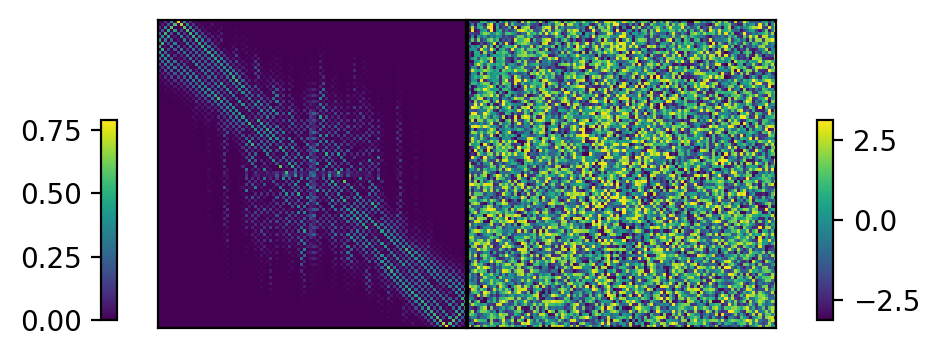

In [66]:
#plt.imshow(p_matrix)
#plt.show()
plt2_trans(t_matrix,p_matrix)

In [43]:
c_matrix_49 = Husimi.coh_Dkl_b(49)  # 

In [64]:
c_matrix_100 = Husimi.coh_Dkl_b(100)  # 

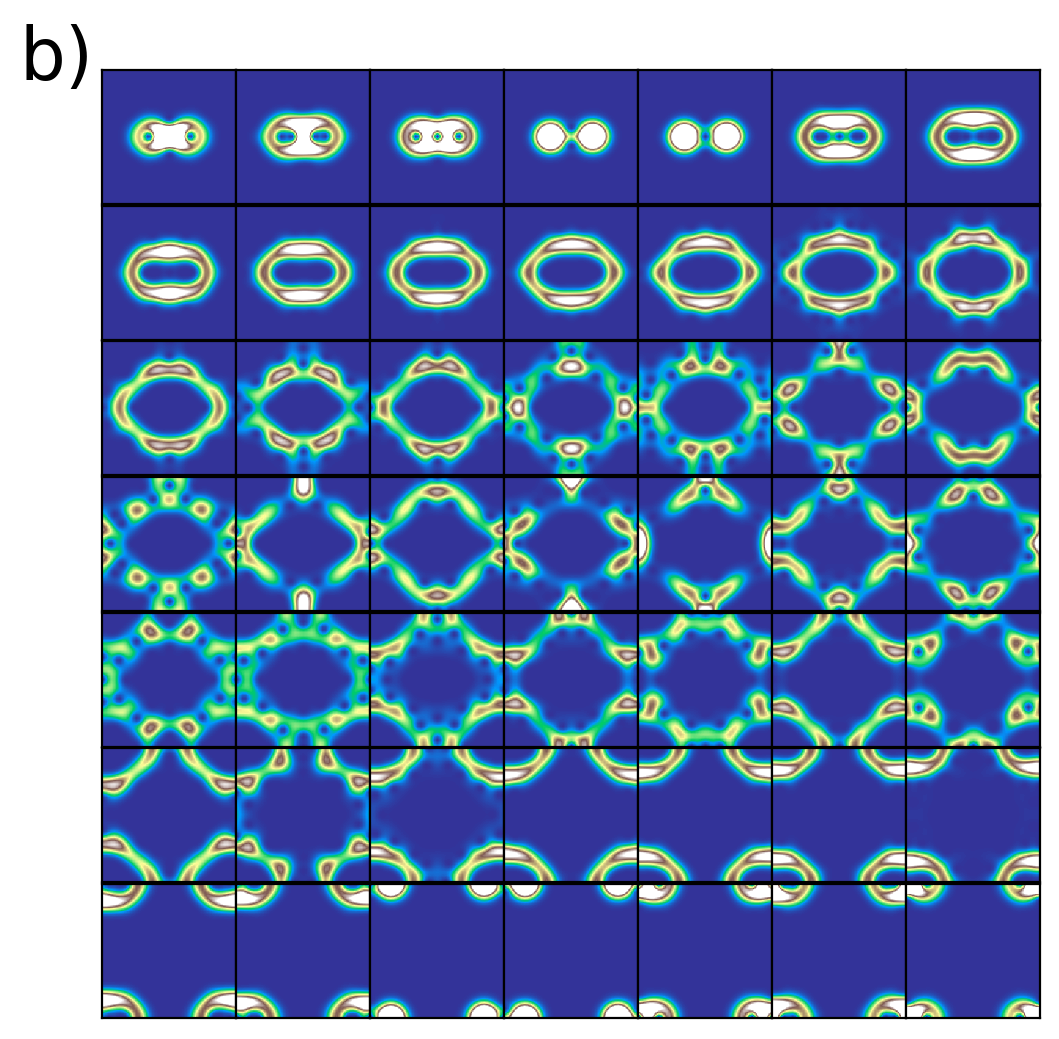

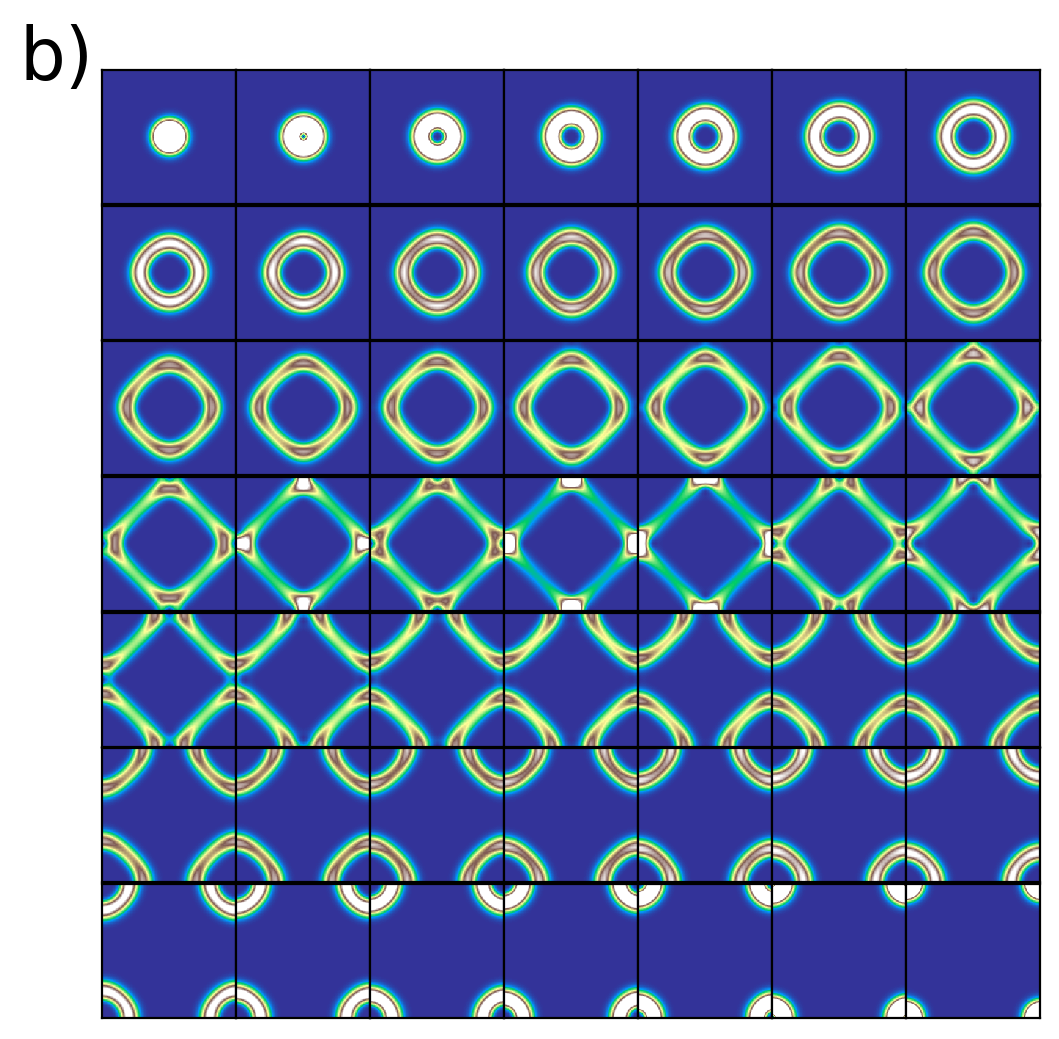

In [58]:
Hmatrix_big_last = Husimi.stor_Hus(np.squeeze(vrsort_list[-1,:,:]),c_matrix_49)
Hmatrix_big_first = Husimi.stor_Hus(np.squeeze(vrsort_list[0,:,:]),c_matrix_49)
Husimi.show_Hus(Hmatrix_big_last,'',0)
Husimi.show_Hus(Hmatrix_big_first,'',0)

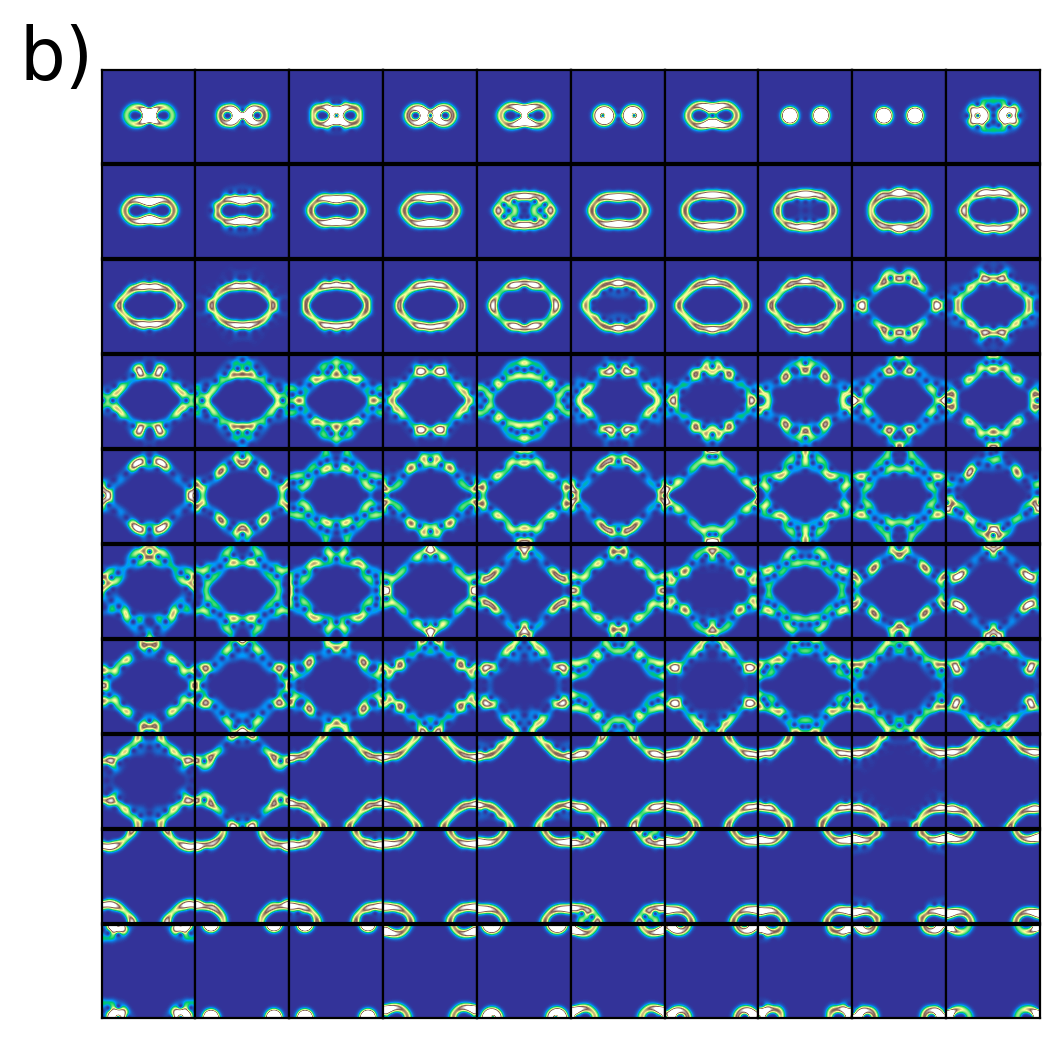

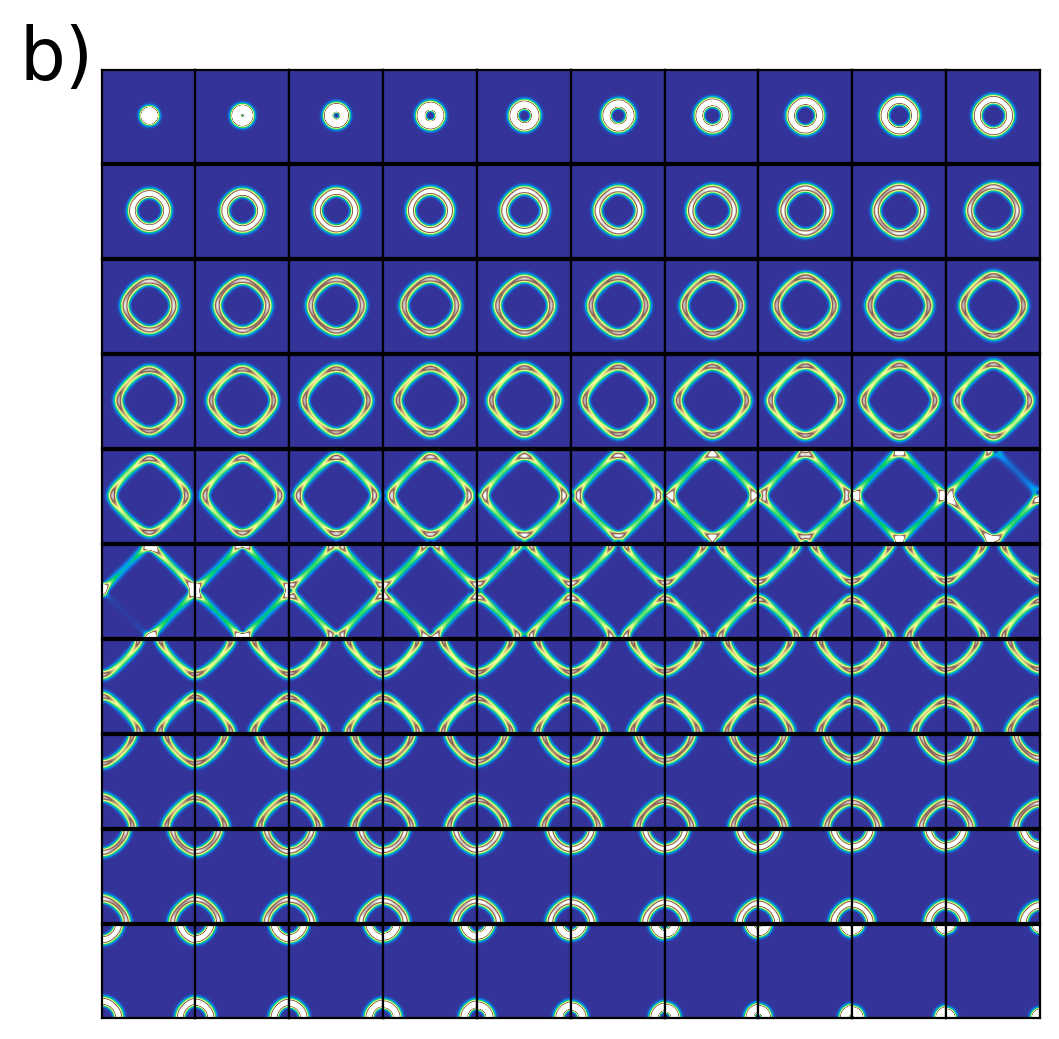

In [67]:
Hmatrix_big_last = Husimi.stor_Hus(np.squeeze(vrsort_list[-1,:,:]),c_matrix_100)
Hmatrix_big_first = Husimi.stor_Hus(np.squeeze(vrsort_list[0,:,:]),c_matrix_100)
Husimi.show_Hus(Hmatrix_big_last,'',0)
Husimi.show_Hus(Hmatrix_big_first,'',0)

In [15]:
# routines for classical drifting system integration 

# What if parameter $a,b,\epsilon,\mu, \mu_p$ all drift?

# dy/dt = func(y,t), needed for integrator!
# note that y[0] = phi and y[1] = p
def func(y,tau,parms0,dparmsdt):
    parms = parms0 + dparmsdt*tau  # parameters drifting here 
    a = parms[0]
    b = parms[1]
    eps = parms[2]
    mu = parms[3]
    mup = parms[4]
    return [a*np.sin(y[1] - b) ,\
                -epsilon*np.sin(y[0]) - mu*np.sin(y[0] - tau) - mup*np.sin(y[0] + tau)]


In [22]:
# compute coherent states in advance
c_matrix_100 = Husimi.coh_Dkl_b(100)  # 

In [13]:
c_matrix_49 = Husimi.coh_Dkl_b(49)  # 

In [15]:
# class structure to store a specific dynamical system 
# requires c_matrix, storing coherent states to be made ahead of time
class Hsys:
    def __init__(self,n,ntau,a,b,eps,mu,mup,c_matrix):
        self.n = n
        self.ntau = ntau
        self.a = a
        self.b = b
        self.eps = eps
        self.mu = mu
        self.mup = mup
        # compute the propagator and eigenfunctions and eigenvalues
        w,vr,Up= Husimi.U_prop2(n,ntau,a,b,eps,mu,mup)
        self.w = w
        self.vr = vr
        self.Up = Up
        self.c_matrix = c_matrix
        # compute Husimi distribution
        self.Hmatrix_big = Husimi.stor_Hus(self.vr,c_matrix)
        
    def Hus(self,froot):   # show Husimi distribution
        Husimi.show_Hus(self.Hmatrix_big,froot)  
            
    def circ(self,froot):  # show stuff about eigenvalues 
        Husimi.mk_plots_circ(self.w,froot) 
        
    def classical(self,froot):  # show classical phase space 
        norb=100
        npoints=200
        Harp.mkfig_cl(norb,npoints,self.a,self.b,self.eps,self.mu,self.mup,froot)
          

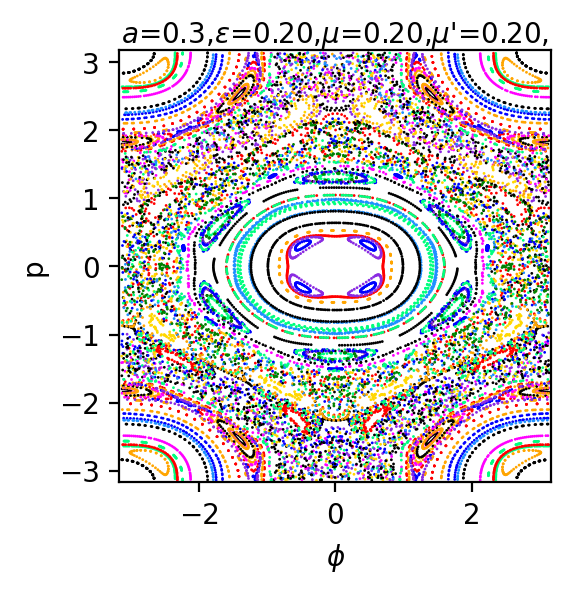

In [75]:
n=49; ntau=400; a = 0.3; b=0.0; eps = 0.2; mu = 0.2; mup=mu; 
sim2= Hsys(n,ntau,a,b,eps,mu,mup,c_matrix_49) 
froot = ''
#sim2.Hus(froot)
sim2.classical(froot)
#sim2.circ(froot)

0.2 0.04


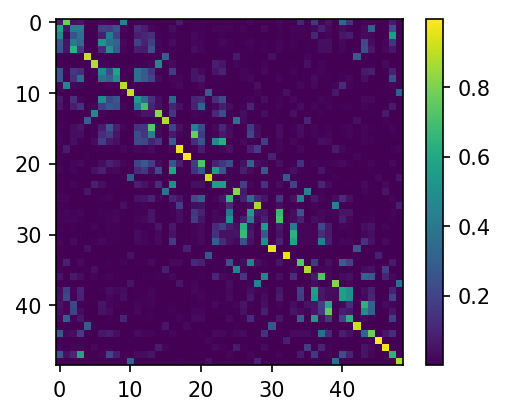

In [94]:
n=49; ntau=400;  a = 0.3; b=0; eps = 0.2; mu = 0.2; mup=mu;  
parms0 = np.array([a,b,eps,mu,mup])
d_mu = 0 # 0.0005
d_b = 0.0002
d_parms = np.array([0.0,d_b,0.0,d_mu,0.0])
nseries=200
w_list,vr_list,w_var_list,vr_var_list,Ut,t_matrix,Hmatrix_big0, Hmatrix_big1 = \
   U_prop_series(n,ntau,parms0,d_parms,nseries)
a_list = np.angle(w_list) # lists of eigenvalues phases one for each step
a_var_list = np.angle(w_var_list)  # consecutive eigenvalue phases each step of propagator
print(mu+nseries*d_mu, b+ nseries*d_b)

fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
im = ax.imshow(t_matrix)
plt.colorbar(im)

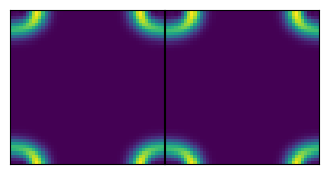

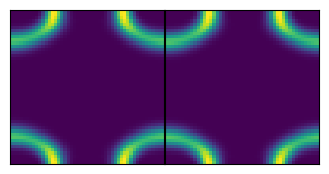

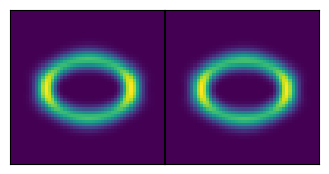

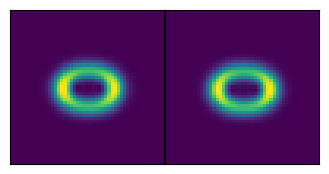

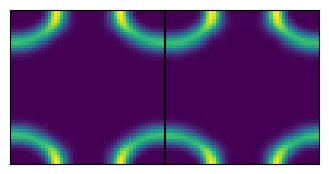

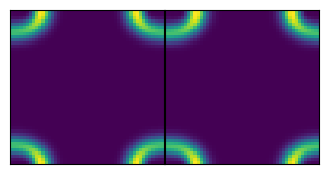

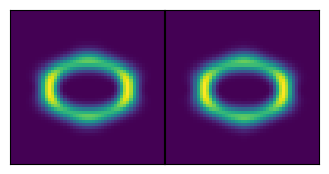

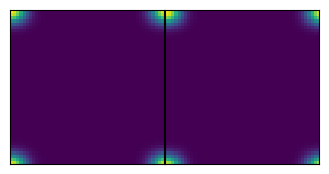

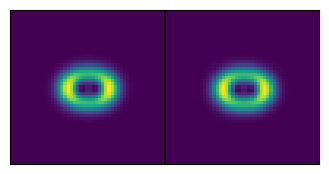

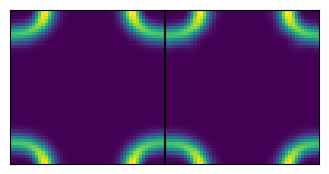

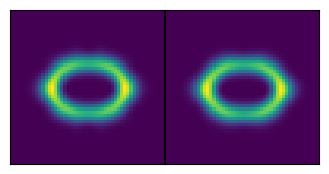

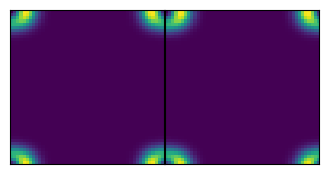

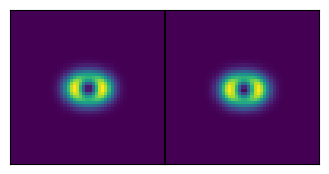

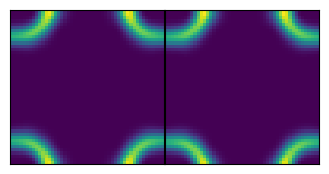

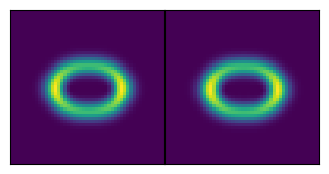

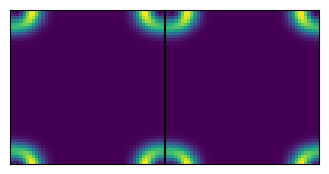

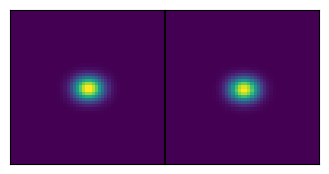

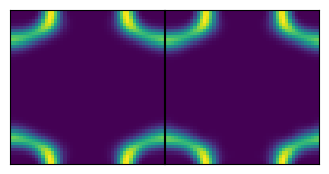

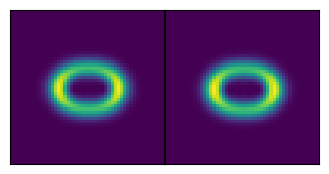

In [96]:
for i in range(n):
    for j in range(n):
        if (t_matrix[i,j]>0.8):
            plt2_H(np.squeeze(Hmatrix_big0[:,:,i]),np.squeeze(Hmatrix_big1[:,:,j]))

### periodic orbits that remain periodic orbits, evolve adiabatically
that means that energy levels never get too close to each other during adiabatic evolution
even though the system is integrable

/var/folders/l_/tk7gphlj0d38754sb6x8p1f00000gn/T/ipykernel_51046/3786354500.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axarr = plt.subplots(1,2,figsize=(4,2),sharex=True,sharey=True)


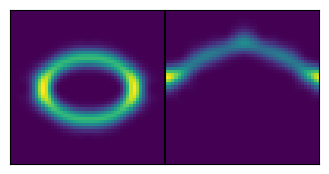

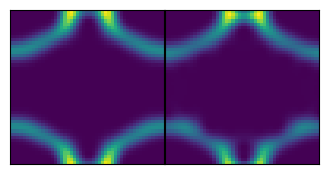

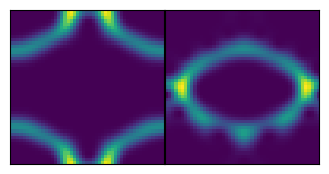

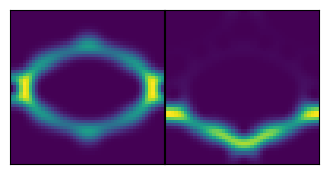

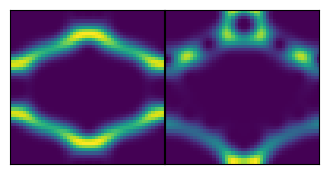

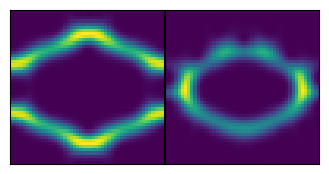

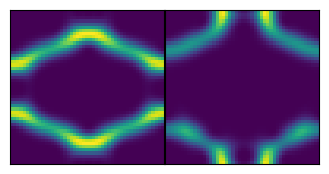

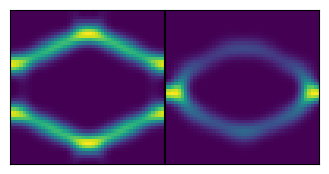

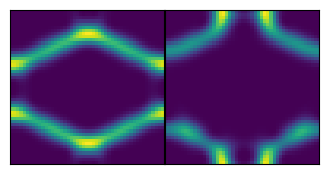

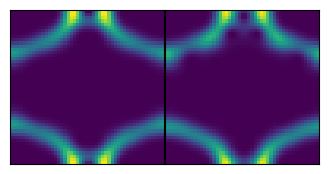

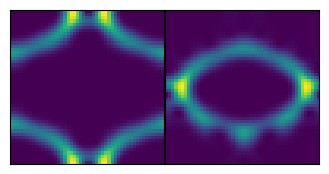

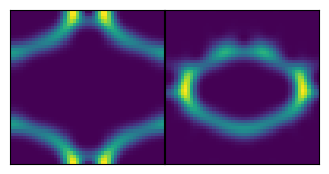

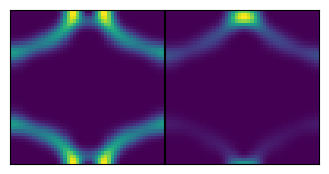

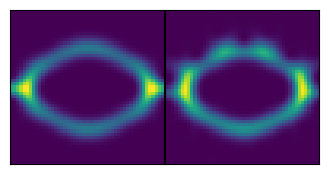

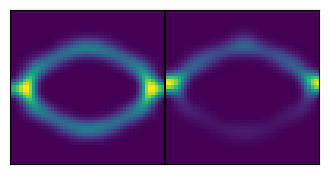

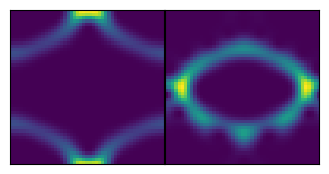

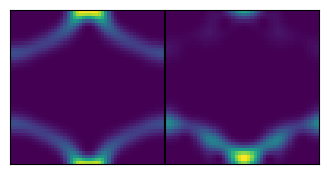

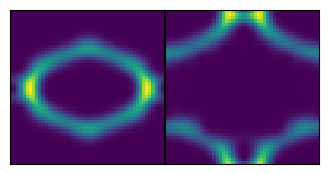

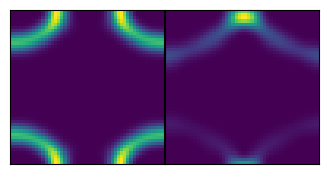

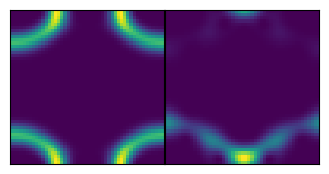

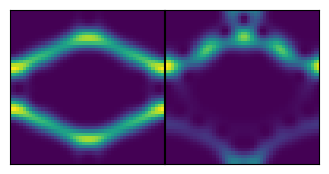

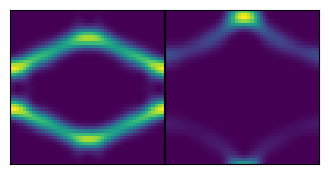

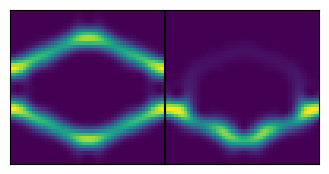

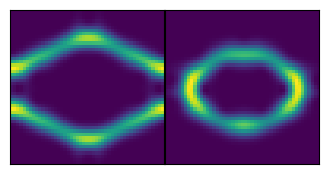

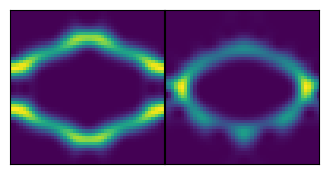

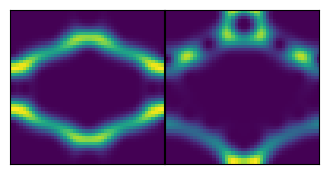

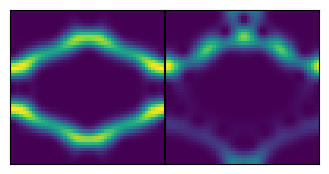

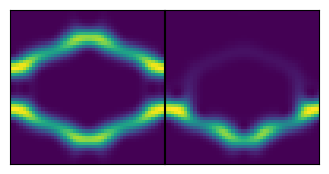

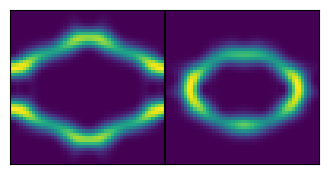

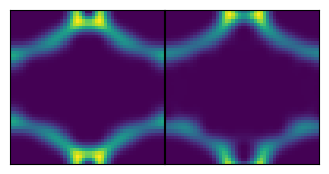

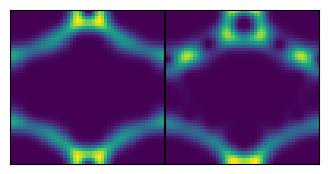

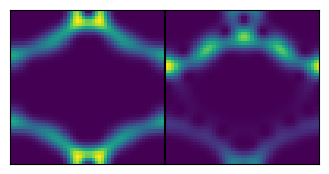

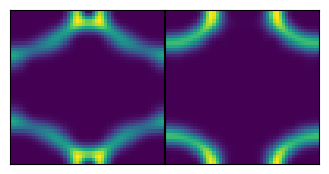

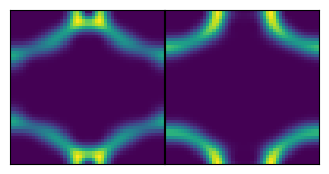

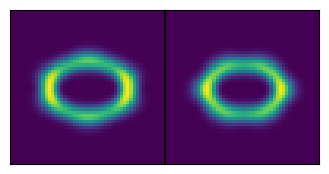

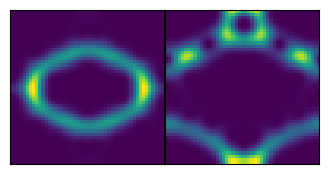

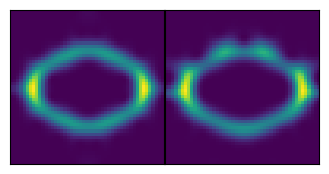

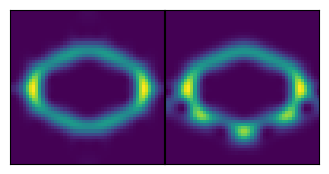

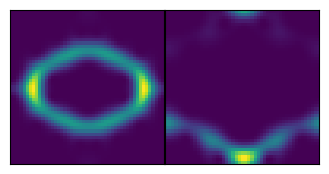

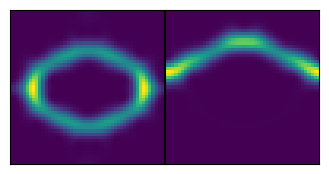

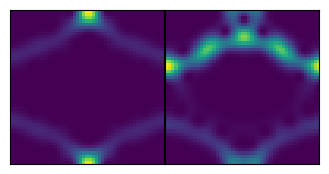

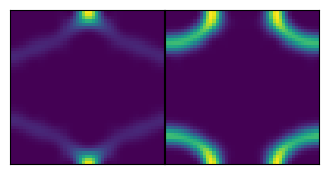

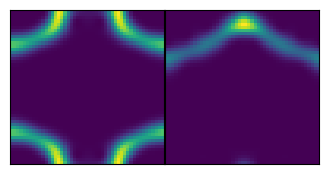

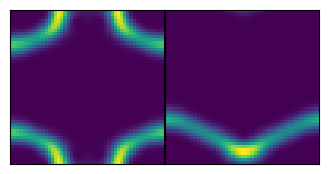

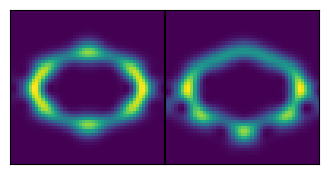

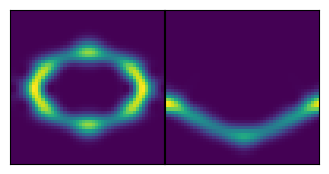

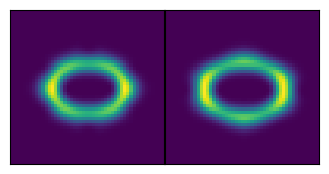

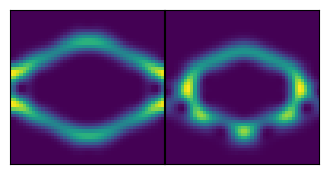

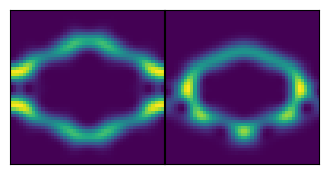

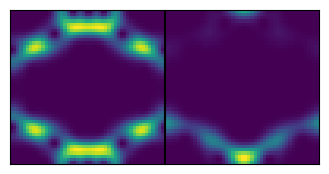

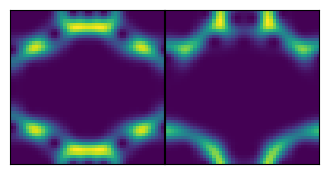

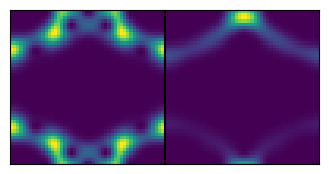

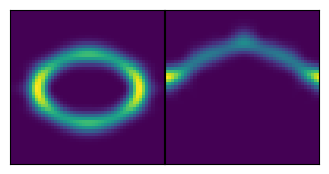

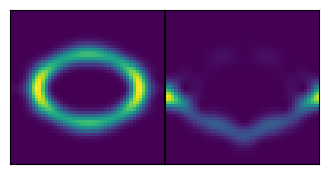

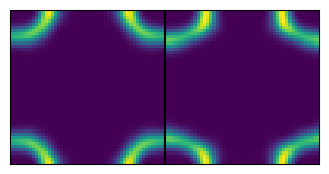

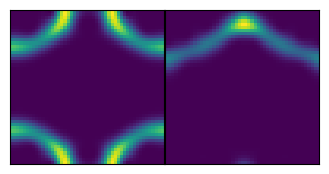

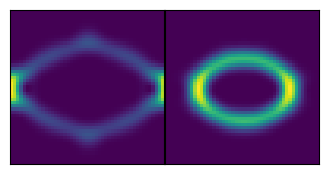

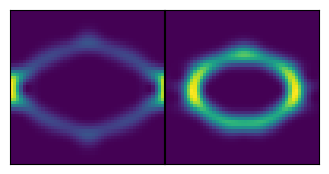

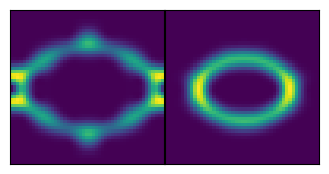

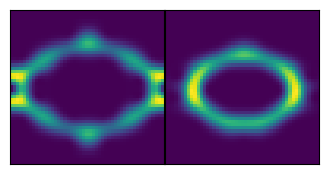

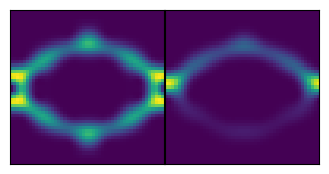

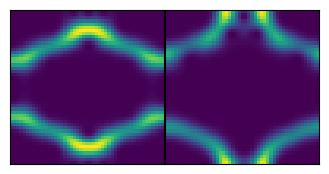

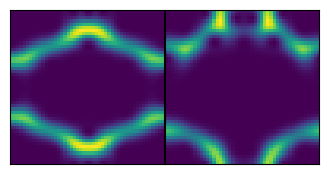

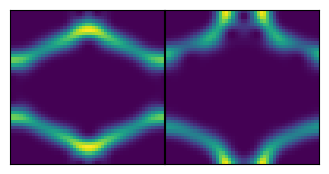

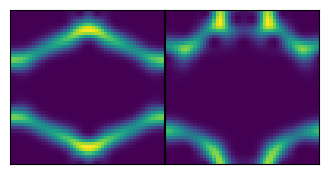

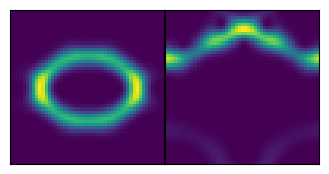

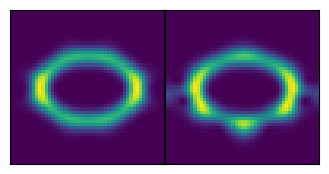

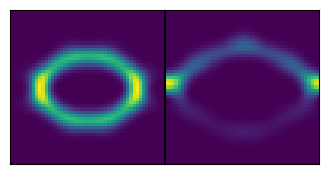

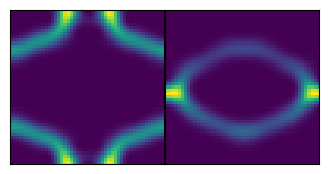

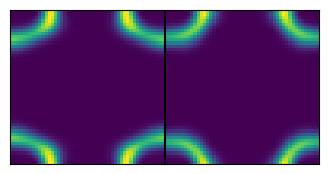

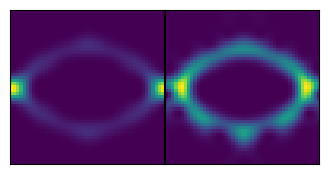

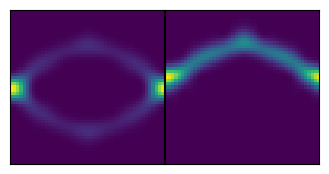

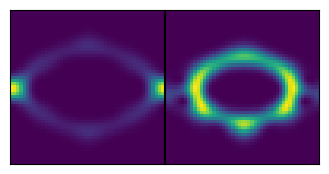

In [98]:
for i in range(n):
    for j in range(n):
        if (t_matrix[i,j]>0.15) and (t_matrix[i,j]<0.24):
            plt2_H(np.squeeze(Hmatrix_big0[:,:,i]),np.squeeze(Hmatrix_big1[:,:,j]))

### orbits near the separatrix do not evolve adiabatically 
even though that is where chaos is present
and we would think that a random matrix model describes the system
Energy levels must get close together during evolution 

What if we start as a random matrix model and only evolve from random to random?

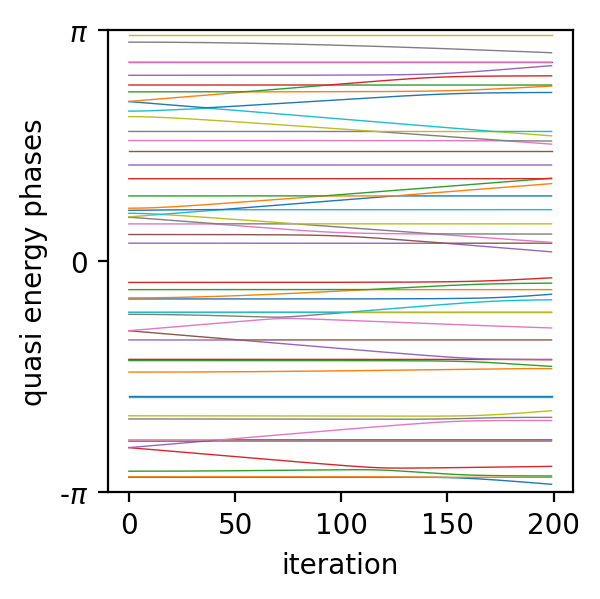

In [100]:
iis = np.arange(nseries)
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
ax.set_ylim([-np.pi,np.pi])
ax.set_yticks([-np.pi,0,np.pi],labels = [r'-$\pi$','0',r'$\pi$'])
for j in range(n):
    ax.plot(iis,np.squeeze(a_list[:,j]),'-',lw=0.5)
ax.set_ylabel('quasi energy phases');
ax.set_xlabel('iteration');

# why are there any changes in quasi energies if b is drifting?  There should not be any changes?
#Hamiltonian before and after are equal except for a shift in p
# H(p,phi)before = H(p-b,phi)after
# orbits are certainty the same, except for a shift, but not sure about operators
# only a few energies seem affected 

# why?

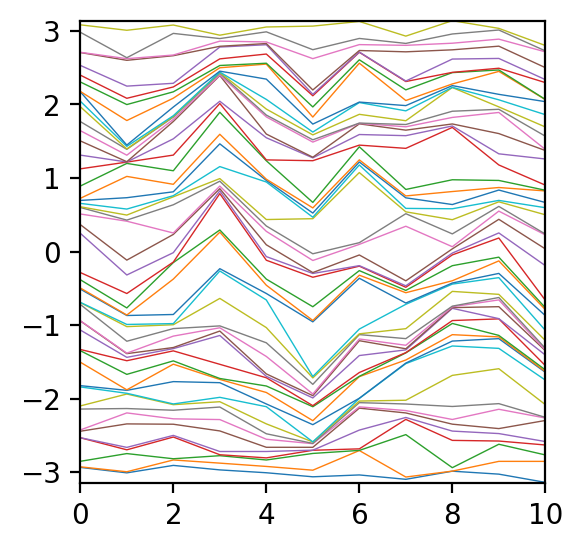

In [106]:
iis = np.arange(nseries)
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
ax.set_ylim([-np.pi,np.pi])
ax.set_xlim([0,10])
for j in range(n):
    ax.plot(iis,np.squeeze(a_var_list[:,j]),'-',lw=0.5)

#absolutely not interesting energies of changing UT integrated 